In [1]:
!pip install torchmetrics
!pip install thop
!pip install yacs
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 74.1 MB/s eta 0:00:00


In [2]:
#import

import zipfile
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from PIL import Image
import os
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
from thop import profile, clever_format

import torch.nn as nn
import torch.optim as optim

from torchmetrics import JaccardIndex
import torch.nn.functional as F
import random

from tqdm import tqdm

import kornia
import time
import logging
from torch.utils import data, model_zoo

In [3]:
!wget https://zenodo.org/record/5706578/files/Train.zip
!wget https://zenodo.org/record/5706578/files/Val.zip

--2025-01-16 07:32:42--  https://zenodo.org/record/5706578/files/Train.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/5706578/files/Train.zip [following]
--2025-01-16 07:32:43--  https://zenodo.org/records/5706578/files/Train.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 4021669263 (3.7G) [application/octet-stream]
Saving to: ‘Train.zip’

Train.zip           100%[===================>]   3.75G  13.0MB/s    in 4m 58s  

2025-01-16 07:37:41 (12.9 MB/s) - ‘Train.zip’ saved [4021669263/4021669263]

--2025-01-16 07:37:41--  https://zenodo.org/record/5706578/files/Val.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request 

In [4]:
!wget https://zenodo.org/records/14606189/files/PIDNet_S_ImageNet.pth.tar

--2025-01-16 07:40:43--  https://zenodo.org/records/14606189/files/PIDNet_S_ImageNet.pth.tar
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38061375 (36M) [application/octet-stream]
Saving to: ‘PIDNet_S_ImageNet.pth.tar’

PIDNet_S_ImageNet.p 100%[===================>]  36.30M  12.5MB/s    in 2.9s    

2025-01-16 07:40:47 (12.5 MB/s) - ‘PIDNet_S_ImageNet.pth.tar’ saved [38061375/38061375]



In [5]:
# Define file paths
train_zip = "Train.zip"
val_zip = "Val.zip"

# Extract Train.zip
with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall("Train")

# Extract Val.zip
with zipfile.ZipFile(val_zip, 'r') as zip_ref:
    zip_ref.extractall("Val")

# Verify the extracted folders
print("Train Directory Contents:", os.listdir("Train"))
print("Val Directory Contents:", os.listdir("Val"))

Train Directory Contents: ['Train']
Val Directory Contents: ['Val']


In [6]:
# Clone the repository and move into the folder
!git clone https://github.com/nazianafis/Neural-Style-Transfer.git
%cd Neural-Style-Transfer

# Install the required dependencies
!pip install -r requirements.txt
%cd ..

import sys
sys.path.append('/content/Neural-Style-Transfer')
file_path = '/content/Neural-Style-Transfer/NST.py'

with open(file_path, "r") as file:
    file_content = file.read()

# Replace the target line with an empty string
updated_content = file_content.replace("results_path = neural_style_transfer(optimization_config)", "")

with open(file_path, "w") as file:
    file.write(updated_content)


# from NST import neural_style_transfer



Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 379 (delta 72), reused 105 (delta 34), pack-reused 225 (from 1)
Receiving objects: 100% (379/379), 92.21 MiB | 27.79 MiB/s, done.
Resolving deltas: 100% (143/143), done.
/content/Neural-Style-Transfer
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.8/89.8 MB 9.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error origina

In [7]:
from NST import prepare_img, prepare_model,Variable,gram_matrix,LBFGS,build_loss,save_and_maybe_display
import shutil

def neural_style_transfer1(config):
    '''
    The main Neural Style Transfer method.
    '''
    content_img_path = os.path.join(config['content_images_dir'], config['content_img_name'])
    # print(content_img_path)
    style_img_path = os.path.join(config['style_images_dir'], config['style_img_name'])
    out_dir_name = 'combined_' + os.path.split(content_img_path)[1].split('.')[0] + '_' + os.path.split(style_img_path)[1].split('.')[0]
    dump_path = os.path.join(config['output_img_dir'], '')
    os.makedirs(dump_path, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    content_img = prepare_img(content_img_path, config['height'], device)
    style_img = prepare_img(style_img_path, config['height'], device)

    init_img = content_img

    optimizing_img = Variable(init_img, requires_grad=True)
    neural_net, content_feature_maps_index_name, style_feature_maps_indices_names = prepare_model(device)
    # print(f'Using VGG19 in the optimization procedure.')
    content_img_set_of_feature_maps = neural_net(content_img)
    style_img_set_of_feature_maps = neural_net(style_img)
    target_content_representation = content_img_set_of_feature_maps[content_feature_maps_index_name[0]].squeeze(axis=0)
    target_style_representation = [gram_matrix(x) for cnt, x in enumerate(style_img_set_of_feature_maps) if cnt in style_feature_maps_indices_names[0]]
    target_representations = [target_content_representation, target_style_representation]
    num_of_iterations = 50

    optimizer = LBFGS((optimizing_img,), max_iter=num_of_iterations, line_search_fn='strong_wolfe')
    cnt = 0

    def closure():
        nonlocal cnt
        if torch.is_grad_enabled():
            optimizer.zero_grad()
        total_loss, content_loss, style_loss, tv_loss = build_loss(neural_net, optimizing_img, target_representations, content_feature_maps_index_name[0], style_feature_maps_indices_names[0], config)
        if total_loss.requires_grad:
            total_loss.backward()
        with torch.no_grad():
            # print(f'L-BFGS | iteration: {cnt:03}, total loss={total_loss.item():12.4f}, content_loss={config["content_weight"] * content_loss.item():12.4f}, style loss={config["style_weight"] * style_loss.item():12.4f}, tv loss={config["tv_weight"] * tv_loss.item():12.4f}')
            save_and_maybe_display(optimizing_img, dump_path, config, cnt, num_of_iterations)
        cnt += 1
        return total_loss
    optimizer.step(closure)
    return dump_path


PATH = '/content/'

default_resource_dir = os.path.join(PATH, '')
content_images_dir = os.path.join(PATH, 'Train/Train/Urban/images_png/')
content_masks_dir = os.path.join(PATH, 'Train/Train/Urban/masks_png/')
style_images_dir = os.path.join(PATH, 'Train/Train/Rural/images_png/')
# print(content_images_dir)

# Crea le liste dei file
content_files = [f for f in os.listdir(content_images_dir) if os.path.isfile(os.path.join(content_images_dir, f))]
masks_files = [f for f in os.listdir(content_masks_dir) if os.path.isfile(os.path.join(content_masks_dir, f))]

style_files = [f for f in os.listdir(style_images_dir) if os.path.isfile(os.path.join(style_images_dir, f))]

# Conta il numero di file
num_content_files = len(content_files)
num_style_files = len(style_files)

random.seed(42)  # Cambia il valore per ottenere risultati diversi
print(f"Number of files in content images directory: {num_content_files}")
print(f"Number of files in style images directory: {num_style_files}")
output_dir = '/content/output/'  # Cambia con il percorso corretto

output_masks_png_dir = os.path.join(output_dir, 'masks_png')

os.makedirs(output_masks_png_dir, exist_ok=True)

content_files = content_files
counter = 0
for CONTENT_IMAGE in content_files:
    STYLE_IMAGE = random.choice(style_files) if style_files else None
    counter +=1
    print(CONTENT_IMAGE, STYLE_IMAGE, counter)


    # CONTENT_IMAGE = '1366.png'
    # STYLE_IMAGE = '2.png'

    output_img_dir = os.path.join(default_resource_dir, 'output/images_png')
    output_mask_dir = os.path.join(default_resource_dir, 'output/masks_png')
    mask_file =   os.path.join(content_masks_dir, CONTENT_IMAGE)
    new_name = os.path.join(output_mask_dir,CONTENT_IMAGE.removesuffix(".png") + "_" + STYLE_IMAGE)
    if os.path.exists(mask_file):
        shutil.copy(mask_file, new_name)
        # print(f"File della maschera {CONTENT_IMAGE} copiato in {output_mask_dir}")
    else:
        print(f"Il file della maschera {CONTENT_IMAGE} non esiste in {output_mask_dir}")


    img_format = (4, '.png')

    optimization_config = {'content_img_name': CONTENT_IMAGE, 'style_img_name': STYLE_IMAGE, 'height': 512, 'content_weight': 100000.0, 'style_weight': 30000.0, 'tv_weight': 1.0}
    optimization_config['content_images_dir'] = content_images_dir
    # print(optimization_config['content_images_dir'] )
    optimization_config['style_images_dir'] = style_images_dir
    optimization_config['output_img_dir'] = output_img_dir
    optimization_config['output_mask_dir'] = output_mask_dir
    optimization_config['img_format'] = img_format
    results_path = neural_style_transfer1(optimization_config)

Number of files in content images directory: 1156
Number of files in style images directory: 1366
2066.png 213.png 1


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 62.4MB/s]


1887.png 1041.png 2
1950.png 154.png 3
2103.png 1352.png 4
1858.png 332.png 5
1676.png 889.png 6
2154.png 1034.png 7
1732.png 1029.png 8
1524.png 1340.png 9
2214.png 1020.png 10
2129.png 409.png 11
1801.png 698.png 12
2457.png 1302.png 13
1544.png 938.png 14
1880.png 1260.png 15
2306.png 998.png 16
1707.png 25.png 17
1370.png 806.png 18
1480.png 1291.png 19
2027.png 612.png 20
2133.png 1323.png 21
2184.png 1178.png 22
1686.png 1335.png 23
2372.png 1340.png 24
2191.png 631.png 25
2273.png 1256.png 26
1487.png 63.png 27
1388.png 183.png 28
2277.png 48.png 29
1720.png 543.png 30
1669.png 973.png 31
1926.png 1000.png 32
1868.png 971.png 33
2500.png 48.png 34
1841.png 125.png 35
1465.png 1103.png 36
2127.png 212.png 37
2199.png 1029.png 38
2222.png 980.png 39
2194.png 1076.png 40
1779.png 901.png 41
1476.png 196.png 42
1859.png 82.png 43
1848.png 221.png 44
2301.png 672.png 45
2078.png 135.png 46
1986.png 800.png 47
1916.png 576.png 48
1795.png 76.png 49
2025.png 959.png 50
1985.png 1183.pn

/content/Neural-Style-Transfer/NST.py:75: RuntimeWarning: invalid value encountered in cast
  dump_img = np.clip(dump_img, 0, 255).astype('uint8')


2039.png 97.png 307
1621.png 692.png 308
2416.png 252.png 309
1959.png 112.png 310
2136.png 589.png 311
1791.png 844.png 312
1766.png 633.png 313
2344.png 513.png 314
1447.png 1220.png 315
1968.png 57.png 316
2398.png 56.png 317
2286.png 771.png 318
2037.png 834.png 319
2260.png 1250.png 320
2142.png 675.png 321
2509.png 363.png 322
1703.png 1022.png 323
2196.png 1191.png 324
1878.png 91.png 325
2498.png 659.png 326
1817.png 621.png 327
2365.png 1118.png 328
1641.png 1114.png 329
1385.png 944.png 330
1762.png 532.png 331
1915.png 490.png 332
2135.png 130.png 333
1635.png 932.png 334
1366.png 909.png 335
1706.png 138.png 336
1442.png 46.png 337
1749.png 646.png 338
1821.png 534.png 339
1653.png 244.png 340
1548.png 371.png 341
1683.png 592.png 342
1430.png 490.png 343
1813.png 405.png 344
2420.png 547.png 345
1375.png 248.png 346
1450.png 934.png 347
1788.png 553.png 348
2361.png 179.png 349
1546.png 333.png 350
1970.png 390.png 351
1804.png 424.png 352
2029.png 492.png 353
2160.png 46.

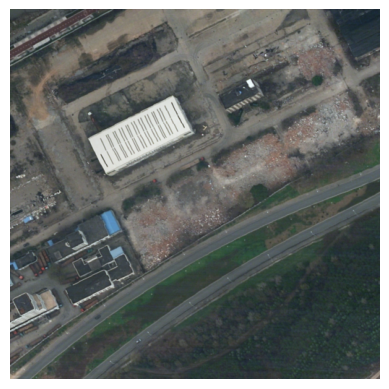

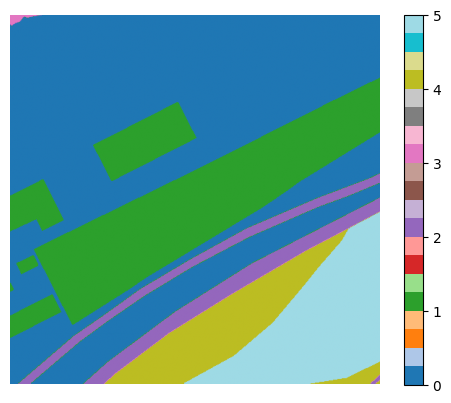

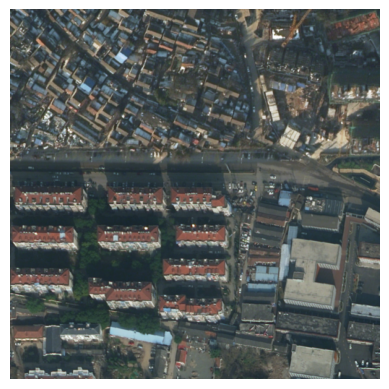

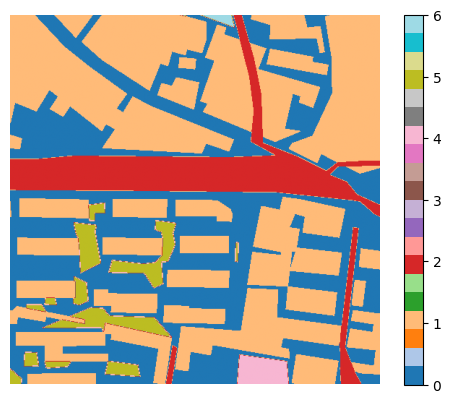

In [9]:
#TASK 5

COLOR_MAP = {
    'Background': 0.00392157,
    'Building': 0.00784314,
    'Road': 0.01176471,
    'Water': 0.01568628,
    'Barren': 0.01960784,
    'Forest': 0.02352941,
    'Agricultural': 0.02745098
}

LABEL_MAP = OrderedDict(
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6
)

# Tolerance-based color to label conversion
def color_to_one_hot(mask, label_map, tolerance=0.001, num_classes=7):
    mask = np.asarray(mask, dtype=np.float32)
    if len(mask.shape) == 2:  # Ensure channel dimension exists
        mask = np.expand_dims(mask, axis=0)  # Convert [H, W] to [1, H, W]

    one_hot_mask = np.zeros((num_classes, mask.shape[1], mask.shape[2]), dtype=np.float32)

    for class_name, class_index in label_map.items():
        color_value = COLOR_MAP[class_name]
        # Match pixels with the grayscale value within the tolerance
        matches = np.abs(mask - color_value) < tolerance
        one_hot_mask[class_index, np.squeeze(matches, axis=0)] = 1.0

    return torch.from_numpy(one_hot_mask)


# Define a function to denormalize the image
def denormalize(tensor, mean, std):
    """ Denormalize the tensor back to the [0, 1] range for visualization. """
    for i in range(len(mean)):
        tensor[i] = tensor[i] * std[i] + mean[i]
    return tensor

def show_image(image_tensor):
    """ Display a transformed image using matplotlib. """
    image_tensor = denormalize(image_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Denormalize the image
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert to HxWxC format
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

def show_mask(mask_tensor, num_classes=7):
    """ Display the mask using matplotlib. """
    # Convert the one-hot mask to the label mask (indices of the highest value per pixel)
    mask = mask_tensor.squeeze().cpu().numpy()  # Remove the batch dimension and convert to numpy
    label_mask = np.argmax(mask, axis=0)  # Get the class index with the highest value for each pixel

    plt.imshow(label_mask, cmap='tab20')  # Use a colormap suitable for categorical data
    plt.colorbar()  # Optionally add a color bar
    plt.axis('off')  # Hide axes
    plt.show()


def colorJitter(colorJitter, img_mean, data = None, target = None, s=0.25):
    # s is the strength of colorjitter
    #colorJitter
    if not (data is None):
        if data.shape[1]==3:
            if colorJitter > 0.2:
                img_mean, _ = torch.broadcast_tensors(img_mean.unsqueeze(0).unsqueeze(2).unsqueeze(3), data)
                seq = nn.Sequential(kornia.augmentation.ColorJitter(brightness=s,contrast=s,saturation=s,hue=s))
                data = (data+img_mean)/255
                data = seq(data)
                data = (data*255-img_mean).float()
    return data, target

def gaussian_blur(blur, data = None, target = None):
    if not (data is None):
        if data.shape[1]==3:
            if blur > 0.5:
                sigma = np.random.uniform(0.15,1.15)
                kernel_size_y = int(np.floor(np.ceil(0.1 * data.shape[2]) - 0.5 + np.ceil(0.1 * data.shape[2]) % 2))
                kernel_size_x = int(np.floor(np.ceil(0.1 * data.shape[3]) - 0.5 + np.ceil(0.1 * data.shape[3]) % 2))
                kernel_size = (kernel_size_y, kernel_size_x)
                seq = nn.Sequential(kornia.filters.GaussianBlur2d(kernel_size=kernel_size, sigma=(sigma, sigma)))
                data = seq(data)
    return data, target

def strongTransform(parameters, data=None, target=None):
    assert ((data is not None) or (target is not None))
    # data, target = transformsgpu.oneMix(mask = parameters["Mix"], data = data, target = target)
    data, target = colorJitter(colorJitter = parameters["ColorJitter"], img_mean = torch.from_numpy(IMG_MEAN.copy()).cuda(), data = data, target = target)
    data, target = gaussian_blur(blur = parameters["GaussianBlur"], data = data, target = target)
    # data, target = transformsgpu.flip(flip = parameters["flip"], data = data, target = target)
    return data, target



class LoveDADataset(Dataset):
    def __init__(self, root_dir, split='train', transform_image=None, transform_label=None, subdir="Rural", aug1=False, aug2=False):
        self.root_dir = root_dir
        self.split = split
        self.transform_image = transform_image
        self.transform_label = transform_label
        self.aug1 = aug1
        self.aug2 = aug2
        self.image_paths = []
        self.label_paths = []

        image_dir = os.path.join(root_dir, split, subdir, 'images_png')
        label_dir = os.path.join(root_dir, split, subdir, 'masks_png')

        for f in os.listdir(image_dir):
            if f.endswith('.png'):
                self.image_paths.append(os.path.join(image_dir, f))
                self.label_paths.append(os.path.join(label_dir, f))

    def __len__(self):
        original_length = len(self.image_paths)
        if self.aug1 and self.aug2:
            return original_length * 2
        elif self.aug1 or self.aug2:
            return int(original_length * 1.5)
        else:
            return original_length


    def __getitem__(self, idx):
        original_length = len(self.image_paths)

        # Calcola l'indice originale nel dataset
        idx = idx % original_length

        aug_1 = False
        aug_2 = False
        if(idx < original_length):
            aug_1 = False
            aug_2 = False

        elif(idx >= original_length):
            if(random.random() < 0.5):
                if(self.aug1):
                    aug_1 = True
                    aug_2 = False
                elif(self.aug2):
                    aug_1 = False
                    aug_2 = True

            else:
                if (self.aug2):
                    aug_1 = False
                    aug_2 = True
                elif(self.aug1):
                    aug_1 = True
                    aug_2 = False



        # Carica l'immagine e la maschera
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = Image.open(self.label_paths[idx]).convert("L")

        image_np = np.array(image)
        label_np = np.array(label)

        # Seed per garantire coerenza tra immagine e maschera
        seed = np.random.randint(2147483647)

        # Applica augmentazione se abilitata
        if self.aug1 and aug_1:
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            transform_aug1 = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(30)
            ])
            image = Image.fromarray(image_np)
            image = transform_aug1(image)
            image_np = np.array(image)

            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            label = Image.fromarray(label_np)
            label = transform_aug1(label)
            label_np = np.array(label)

        if self.aug2 and aug_2:
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            strong_parameters = {}
            strong_parameters["ColorJitter"] = random.uniform(0, 1)
            strong_parameters["GaussianBlur"] = random.uniform(0, 1)


            image = Image.fromarray(image_np)
            image, _ = strongTransform(strong_parameters, image, None)
            image_np = np.array(image)

            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            label = Image.fromarray(label_np)

            label_np = np.array(label)

        # Trasformazioni opzionali per immagine e maschera
        if self.transform_image:
            transform_image_alb = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            image = Image.fromarray(image_np)
            image = transform_image_alb(image)

        if self.transform_label:
            transform_label_alb = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor()
            ])
            label = Image.fromarray(label_np)
            label = transform_label_alb(label).squeeze(0)
            label = color_to_one_hot(label, LABEL_MAP)

        return image,label

# Define transformations without augmentations
transform_image = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

transform_label = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Set augmentation flags
AUG1 = True
AUG2 = True

BATCH_SIZE = 16 #or 32, or 64 ...
NUM_WORKERS = 2 # Number of cpu cores
PIN_MEMORY = True
PERSISTENT_WORKERS = False # Set true if you have persistent workers issues
# Create dataset and dataloader with augmentations
train_dataset = LoveDADataset(root_dir='Train/', split='Train', transform_image=transform_image, transform_label=transform_label, subdir='Urban', aug1=AUG1, aug2=AUG2)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)
train2_dataset = LoveDADataset(root_dir='output/', split='', transform_image=transform_image, transform_label=transform_label, subdir='', aug1=AUG1, aug2=AUG2)
train2_loader = DataLoader(train2_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)


val_dataset = LoveDADataset(root_dir='Val/', split='Val', transform_image=transform_image, transform_label=transform_label, subdir='Rural')
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# Visualize the first batch of images
for i, (image, label) in enumerate(train_loader):
    if i == 0:  # Show only the first batch
        show_image(image[0])  # Access the first image of the batch
        show_mask(label[0])
        break


# Definisci una dimensione più piccola per il subset (ad esempio 10% del dataset)
subset_size = 300  # Usa solo i primi 100 campioni per il test

# Usa torch.utils.data.Subset per ottenere un subset casuale dei dati
subset_indices = torch.randperm(len(train_loader.dataset)).tolist()[:subset_size]
train_subset = torch.utils.data.Subset(train_loader.dataset, subset_indices)

# Crea un DataLoader per il subset
#DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)
train_subset_loader = DataLoader(train_subset, batch_size=2, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)
# train_loader = train_subset_loader

for i, (image, label) in enumerate(train_subset_loader):
    if i == 0:  # Show only the first batch
        show_image(image[0])  # Access the first image of the batch
        show_mask(label[0])
        break


Visualizing image 1


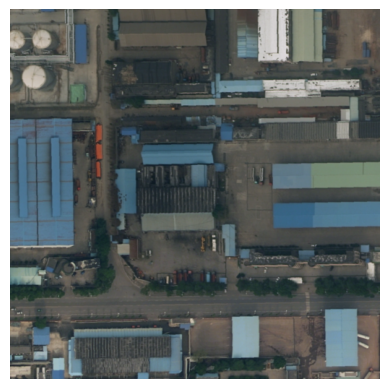

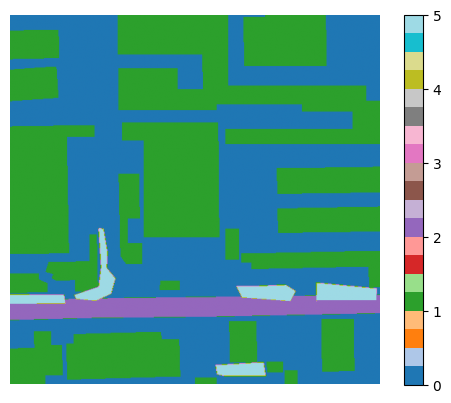

In [10]:
# Funzione per visualizzare immagini con augmentations applicate
def visualize_augmented_images(dataloader, num_images=1):
    """
    Visualizza immagini con augmentations applicate.
    Args:
        dataloader: Il DataLoader dal quale prelevare le immagini.
        num_images: Numero di immagini da visualizzare.
    """
    count = 0
    for images, labels in dataloader:
        for i in range(images.size(0)):
            if count >= num_images:
                return  # Mostra solo il numero richiesto di immagini
            print(f"Visualizing image {count + 1}")
            show_image(images[i])  # Visualizza l'immagine
            show_mask(labels[i])  # Visualizza la maschera
            count += 1

# Visualizza immagini con augmentations dal train_loader
visualize_augmented_images(train_loader, num_images=1)

In [11]:
!git clone https://github.com/XuJiacong/PIDNet.git
%cd content

Cloning into 'PIDNet'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 386 (delta 131), reused 125 (delta 125), pack-reused 193 (from 1)
Receiving objects: 100% (386/386), 212.80 MiB | 35.34 MiB/s, done.
Resolving deltas: 100% (184/184), done.
[Errno 2] No such file or directory: 'content'
/content


In [12]:
import sys
sys.path.append('/content/PIDNet/models')
sys.path.append('/content/PIDNet/utils')
sys.path.append('/content/PIDNet')
# sys.path.remove('/content')
if '/content/Neural-Style-Transfer' in sys.path:
    sys.path.remove('/content/Neural-Style-Transfer')
print(sys.path)
%cd /content/
%ls


['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython', '/tmp/tmptzoj49ln', '/content/PIDNet/models', '/content/PIDNet/utils', '/content/PIDNet']
/content
Neural-Style-Transfer/  PIDNet/                    sample_data/  Train.zip  Val.zip
output/                 PIDNet_S_ImageNet.pth.tar  Train/        Val/


In [13]:
from model_utils import BasicBlock, Bottleneck, segmenthead, DAPPM, PAPPM, PagFM, Bag, Light_Bag
from criterion import CrossEntropy, OhemCrossEntropy, BondaryLoss


BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_


def get_seg_model(name, num_classes, imgnet_pretrained, model_pth):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=True)



    if imgnet_pretrained:

        pretrained_state = torch.load(model_pth, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        model.load_state_dict(model_dict, strict = False)

    else:

        pretrained_dict = torch.load(model_pth, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_seg_model(name='pidnet_s', num_classes=7, imgnet_pretrained=True, model_pth='PIDNet_S_ImageNet.pth.tar').to(device)




vamos


<ipython-input-13-e249c538d1fa>:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(model_pth, map_location='cpu')['state_dict']


In [ ]:
# # Load and visualize an image and its corresponding label
# image_path = "Train/Train/Urban/images_png/1673.png"
# image_path1 = "Train/Train/Rural/images_png/1141.png"
# image_path2 = "output/images_png/1673_1141.png"
# # label_path = "Train/Train/Urban/masks_png/1673.png"

# image = Image.open(image_path)
# image1 = Image.open(image_path1)
# image2 = Image.open(image_path2)
# # label = Image.open(label_path)

# # Display
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title("Image")
# plt.imshow(image)
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title("Image")
# plt.imshow(image1)
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.title("Image")
# plt.imshow(image2)
# plt.show()

| **Train Urban**                         | **Train Rural**                         | **Combination**                         |
|-----------------------------------------|------------------------------------------|------------------------------------------|
| 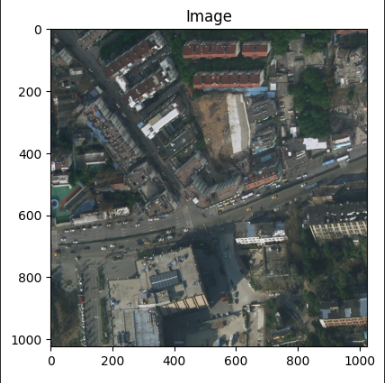    | 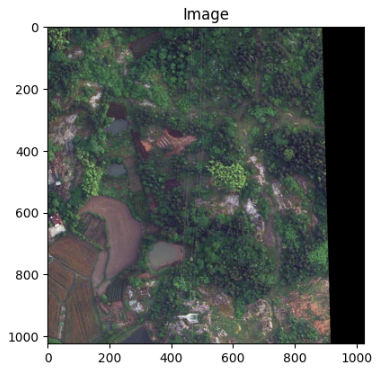   | 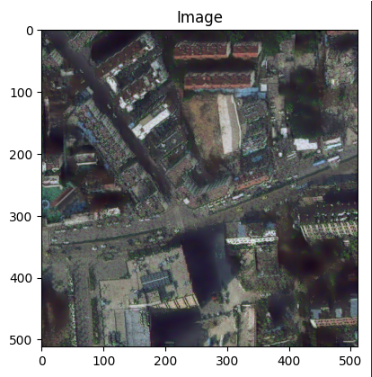  |
|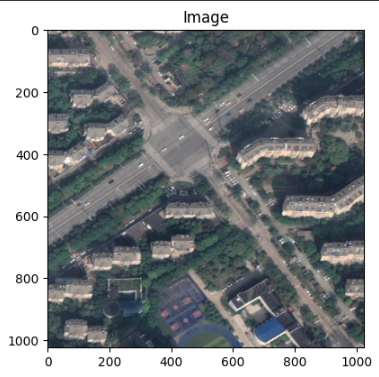|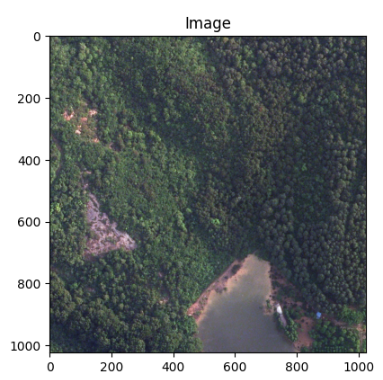|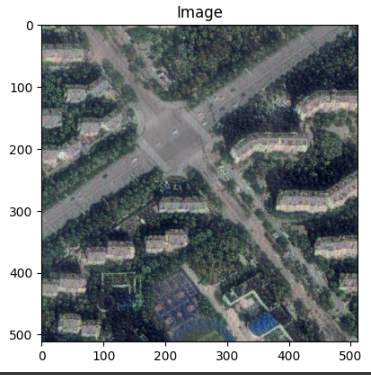|

In [29]:
num_classes=7

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate

# random - experience
class_weights = torch.FloatTensor([0.8373, 0.918, 0.866, 1.0345,
                                        1.0166, 0.9969, 0.9754]).cuda()

# Define the loss function
# criterion = nn.CrossEntropyLoss()
criterion = OhemCrossEntropy(ignore_label=255,
                                        thres=0.9,
                                        min_kept=131072,
                                        weight=class_weights)

# Define mIoU metric
jaccard = JaccardIndex(task="multiclass", num_classes=7).to('cuda')  # intersection over union. Directly measures the overlap between predicted segmentation and ground truth.
def train(images, masks, running_loss):
    images, masks = images.to(device), masks.to(device)

    # Zero gradients, perform a backward pass, and update the weights
    optimizer.zero_grad()
    outputs = model(images)
    main_output = outputs[1]

    # Upsample model outputs to match the target resolution (512x512)
    outputs_resized = F.interpolate(main_output, size=(masks.shape[2], masks.shape[3]), mode='bilinear', align_corners=False)

    # Ensure masks are in the right shape and type (long)
    masks = masks.squeeze(1)  # Remove extra channel dimension and convert to long

    # Calculate loss
    masks = masks.argmax(dim=1)  # Convert to class indices

    # Calculate loss
    loss = criterion(outputs_resized, masks)  # Use CrossEntropyLoss
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    # Update tqdm progress bar with real-time loss using set_postfix
    train_progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
    return running_loss



# Training loop
num_epochs = 20 #20
best_miou = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_progress_bar = tqdm(train2_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") # train_loader
    for images, masks in train_progress_bar:
        running_loss = train(images, masks, running_loss)

    avg_loss = running_loss / len(train_loader) #len(train_subset_loader) #len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {avg_loss:.4f}")

    # Clear GPU memory
    torch.cuda.empty_cache()

    # Validation loop
    model.eval()
    val_miou = 0.0
    val_class_iou = torch.zeros(len(LABEL_MAP)).to('cuda')  # Store IoU per class
    val_class_counts = torch.zeros(len(LABEL_MAP)).to('cuda')  # To track number of pixels for each class

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to('cuda'), masks.to('cuda')

            # Forward pass
            outputs = model(images)  # [batch_size, num_classes, 64, 64]
            main_output = outputs[1]
            preds = torch.argmax(main_output, dim=1)  # [batch_size, 64, 64]

            # Convert masks to class indices format if one-hot encoded
            if masks.ndim == 4:  # [batch_size, num_classes, height, width]
                masks = masks.argmax(dim=1)  # [batch_size, height, width]

            # Resize preds to match the size of the masks
            preds_resized = F.interpolate(preds.unsqueeze(1).float(), size=masks.shape[1:], mode='nearest').squeeze(1).long()

            # Calculate per-class IoU
            for c, class_name in LABEL_MAP.items():  # Iterate over LABEL_MAP classes
                true_class = (masks == class_name)
                pred_class = (preds_resized == class_name)

                intersection = torch.sum(true_class & pred_class).float()
                union = torch.sum(true_class | pred_class).float()

                if union != 0:
                    val_class_iou[class_name] += intersection / union
                val_class_counts[class_name] += 1

            # Calculate overall mIoU for this batch
            val_miou += jaccard(preds_resized, masks)

    # Average metrics
    val_miou /= len(val_loader)

    # Calculate average IoU for each class
    avg_class_iou = val_class_iou / val_class_counts

    # Print validation metrics at the end of each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Validation mIoU: {val_miou:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}] - Per-Class IoU: {dict(zip(LABEL_MAP.keys(), avg_class_iou.tolist()))}")

    # Save the best model
    if val_miou > best_miou:
        best_miou = val_miou
        torch.save(model.state_dict(), 'best_pidnet_model.pth')

print(f"Best Validation mIoU: {best_miou:.4f}")


Epoch 1/20: 100%|██████████| 143/143 [01:36<00:00,  1.48batch/s, loss=0.4078]

Epoch [1/20] Loss: 0.3871


Epoch [1/20] - Validation mIoU: 0.1811
Epoch [1/20] - Per-Class IoU: {'Background': 0.40065181255340576, 'Building': 0.18528561294078827, 'Road': 0.15164005756378174, 'Water': 0.41004449129104614, 'Barren': 0.05617968365550041, 'Forest': 0.019982168450951576, 'Agricultural': 0.044229548424482346}


Epoch 2/20: 100%|██████████| 143/143 [01:36<00:00,  1.48batch/s, loss=0.3750]

Epoch [2/20] Loss: 0.3616


Epoch [2/20] - Validation mIoU: 0.1649
Epoch [2/20] - Per-Class IoU: {'Background': 0.1986905187368393, 'Building': 0.0735773965716362, 'Road': 0.24262243509292603, 'Water': 0.38395076990127563, 'Barren': 0.09856820106506348, 'Forest': 0.014771615155041218, 'Agricultural': 0.1422768533229828}


Epoch 3/20: 100%|██████████| 143/143 [01:37<00:00,  1.47batch/s, loss=0.3048]

Epoch [3/20] Loss: 0.3377


Epoch [3/20] - Validation mIoU: 0.1963
Epoch [3/20] - Per-Class IoU: {'Background': 0.44314709305763245, 'Building': 0.28954795002937317, 'Road': 0.13159044086933136, 'Water': 0.37199628353118896, 'Barren': 0.06428678333759308, 'Forest': 0.02349855750799179, 'Agricultural': 0.050252024084329605}


Epoch 4/20: 100%|██████████| 143/143 [01:38<00:00,  1.45batch/s, loss=0.3384]

Epoch [4/20] Loss: 0.3287


Epoch [4/20] - Validation mIoU: 0.2546
Epoch [4/20] - Per-Class IoU: {'Background': 0.4453784227371216, 'Building': 0.30618488788604736, 'Road': 0.2511318325996399, 'Water': 0.4815290570259094, 'Barren': 0.07658208906650543, 'Forest': 0.11567701399326324, 'Agricultural': 0.10596276819705963}


Epoch 5/20: 100%|██████████| 143/143 [01:37<00:00,  1.46batch/s, loss=0.3308]

Epoch [5/20] Loss: 0.3208


Epoch [5/20] - Validation mIoU: 0.2081
Epoch [5/20] - Per-Class IoU: {'Background': 0.39178666472435, 'Building': 0.09765860438346863, 'Road': 0.19544140994548798, 'Water': 0.45389026403427124, 'Barren': 0.12262491136789322, 'Forest': 0.02098269574344158, 'Agricultural': 0.1743292212486267}


Epoch 6/20: 100%|██████████| 143/143 [01:36<00:00,  1.48batch/s, loss=0.2989]

Epoch [6/20] Loss: 0.3140


Epoch [6/20] - Validation mIoU: 0.2106
Epoch [6/20] - Per-Class IoU: {'Background': 0.4154878556728363, 'Building': 0.15023855865001678, 'Road': 0.2227199375629425, 'Water': 0.44168373942375183, 'Barren': 0.07372346520423889, 'Forest': 0.05227981135249138, 'Agricultural': 0.11826560646295547}


Epoch 7/20: 100%|██████████| 143/143 [01:37<00:00,  1.46batch/s, loss=0.3452]


Epoch [7/20] Loss: 0.3053
Epoch [7/20] - Validation mIoU: 0.1800
Epoch [7/20] - Per-Class IoU: {'Background': 0.36170855164527893, 'Building': 0.11991547793149948, 'Road': 0.19092914462089539, 'Water': 0.3780724108219147, 'Barren': 0.10226915031671524, 'Forest': 0.01342762354761362, 'Agricultural': 0.09348531067371368}


Epoch 8/20: 100%|██████████| 143/143 [01:40<00:00,  1.42batch/s, loss=0.2913]

Epoch [8/20] Loss: 0.3030


Epoch [8/20] - Validation mIoU: 0.1894
Epoch [8/20] - Per-Class IoU: {'Background': 0.36539867520332336, 'Building': 0.12118802964687347, 'Road': 0.24617671966552734, 'Water': 0.40786242485046387, 'Barren': 0.0649891272187233, 'Forest': 0.04131122678518295, 'Agricultural': 0.07897409796714783}


Epoch 9/20: 100%|██████████| 143/143 [01:37<00:00,  1.46batch/s, loss=0.3279]

Epoch [9/20] Loss: 0.3017


Epoch [9/20] - Validation mIoU: 0.2241
Epoch [9/20] - Per-Class IoU: {'Background': 0.44716551899909973, 'Building': 0.1800583451986313, 'Road': 0.2619338929653168, 'Water': 0.4581158459186554, 'Barren': 0.058204036206007004, 'Forest': 0.05522061884403229, 'Agricultural': 0.10806874185800552}


Epoch 10/20: 100%|██████████| 143/143 [01:37<00:00,  1.47batch/s, loss=0.3291]

Epoch [10/20] Loss: 0.3010


Epoch [10/20] - Validation mIoU: 0.1930
Epoch [10/20] - Per-Class IoU: {'Background': 0.395560622215271, 'Building': 0.17953360080718994, 'Road': 0.234090656042099, 'Water': 0.33211129903793335, 'Barren': 0.072596475481987, 'Forest': 0.034961968660354614, 'Agricultural': 0.10179968923330307}


Epoch 11/20: 100%|██████████| 143/143 [01:37<00:00,  1.47batch/s, loss=0.3121]

Epoch [11/20] Loss: 0.2943


Epoch [11/20] - Validation mIoU: 0.1925
Epoch [11/20] - Per-Class IoU: {'Background': 0.3611336946487427, 'Building': 0.11698974668979645, 'Road': 0.23353908956050873, 'Water': 0.4520457983016968, 'Barren': 0.07635600864887238, 'Forest': 0.03268195316195488, 'Agricultural': 0.07443977892398834}


Epoch 12/20: 100%|██████████| 143/143 [01:38<00:00,  1.45batch/s, loss=0.3330]

Epoch [12/20] Loss: 0.2976


Epoch [12/20] - Validation mIoU: 0.1418
Epoch [12/20] - Per-Class IoU: {'Background': 0.3423576354980469, 'Building': 0.28026083111763, 'Road': 0.181075781583786, 'Water': 0.12223257124423981, 'Barren': 0.036949899047613144, 'Forest': 0.020137356594204903, 'Agricultural': 0.009714794345200062}


Epoch 13/20: 100%|██████████| 143/143 [01:35<00:00,  1.49batch/s, loss=0.3461]

Epoch [13/20] Loss: 0.3007


Epoch [13/20] - Validation mIoU: 0.2141
Epoch [13/20] - Per-Class IoU: {'Background': 0.39429348707199097, 'Building': 0.14804202318191528, 'Road': 0.2530500590801239, 'Water': 0.4232232868671417, 'Barren': 0.07845939695835114, 'Forest': 0.04781113937497139, 'Agricultural': 0.15405699610710144}


Epoch 14/20: 100%|██████████| 143/143 [01:36<00:00,  1.49batch/s, loss=0.3167]

Epoch [14/20] Loss: 0.3041


Epoch [14/20] - Validation mIoU: 0.1910
Epoch [14/20] - Per-Class IoU: {'Background': 0.4279245138168335, 'Building': 0.20389501750469208, 'Road': 0.21477586030960083, 'Water': 0.37361231446266174, 'Barren': 0.035421982407569885, 'Forest': 0.02846171148121357, 'Agricultural': 0.05268189683556557}


Epoch 15/20: 100%|██████████| 143/143 [01:36<00:00,  1.48batch/s, loss=0.3173]

Epoch [15/20] Loss: 0.2952


Epoch [15/20] - Validation mIoU: 0.2064
Epoch [15/20] - Per-Class IoU: {'Background': 0.4156875014305115, 'Building': 0.18452328443527222, 'Road': 0.2427312731742859, 'Water': 0.38308626413345337, 'Barren': 0.06962379068136215, 'Forest': 0.04279179126024246, 'Agricultural': 0.10641153901815414}


Epoch 16/20: 100%|██████████| 143/143 [01:35<00:00,  1.50batch/s, loss=0.3433]

Epoch [16/20] Loss: 0.2943


Epoch [16/20] - Validation mIoU: 0.2071
Epoch [16/20] - Per-Class IoU: {'Background': 0.3934558033943176, 'Building': 0.1513465940952301, 'Road': 0.24315668642520905, 'Water': 0.40594735741615295, 'Barren': 0.07355888187885284, 'Forest': 0.07138499617576599, 'Agricultural': 0.11105789989233017}


Epoch 17/20: 100%|██████████| 143/143 [01:35<00:00,  1.49batch/s, loss=0.3089]

Epoch [17/20] Loss: 0.2957


Epoch [17/20] - Validation mIoU: 0.2102
Epoch [17/20] - Per-Class IoU: {'Background': 0.4223959445953369, 'Building': 0.1621670126914978, 'Road': 0.24478112161159515, 'Water': 0.4461364448070526, 'Barren': 0.07552550733089447, 'Forest': 0.03631416708230972, 'Agricultural': 0.0843602642416954}


Epoch 18/20: 100%|██████████| 143/143 [01:35<00:00,  1.50batch/s, loss=0.3340]


Epoch [18/20] Loss: 0.2943
Epoch [18/20] - Validation mIoU: 0.1828
Epoch [18/20] - Per-Class IoU: {'Background': 0.31935587525367737, 'Building': 0.10337594151496887, 'Road': 0.235479936003685, 'Water': 0.42193034291267395, 'Barren': 0.06471401453018188, 'Forest': 0.047305427491664886, 'Agricultural': 0.08757243305444717}


Epoch 19/20: 100%|██████████| 143/143 [01:36<00:00,  1.49batch/s, loss=0.2849]

Epoch [19/20] Loss: 0.2941


Epoch [19/20] - Validation mIoU: 0.2020
Epoch [19/20] - Per-Class IoU: {'Background': 0.4006004333496094, 'Building': 0.14049729704856873, 'Road': 0.20848190784454346, 'Water': 0.39827242493629456, 'Barren': 0.09084714949131012, 'Forest': 0.05031147226691246, 'Agricultural': 0.1252376139163971}


Epoch 20/20: 100%|██████████| 143/143 [01:37<00:00,  1.46batch/s, loss=0.3483]

Epoch [20/20] Loss: 0.2953


Epoch [20/20] - Validation mIoU: 0.2057
Epoch [20/20] - Per-Class IoU: {'Background': 0.41428133845329285, 'Building': 0.16205278038978577, 'Road': 0.2055160105228424, 'Water': 0.4265879988670349, 'Barren': 0.07644475996494293, 'Forest': 0.0440804697573185, 'Agricultural': 0.11081300675868988}
Best Validation mIoU: 0.2546



Random Sample (Epoch 6)
Input Tensor:  torch.Size([1, 3, 512, 512])
Ground Truth:  torch.Size([7, 512, 512])
Model Output:  1


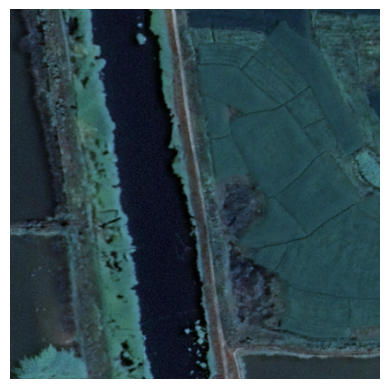

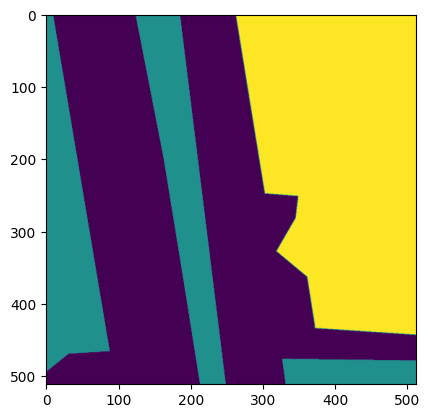

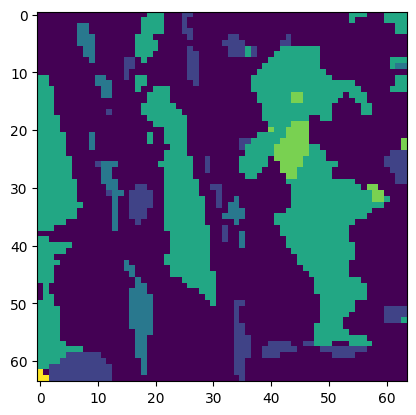

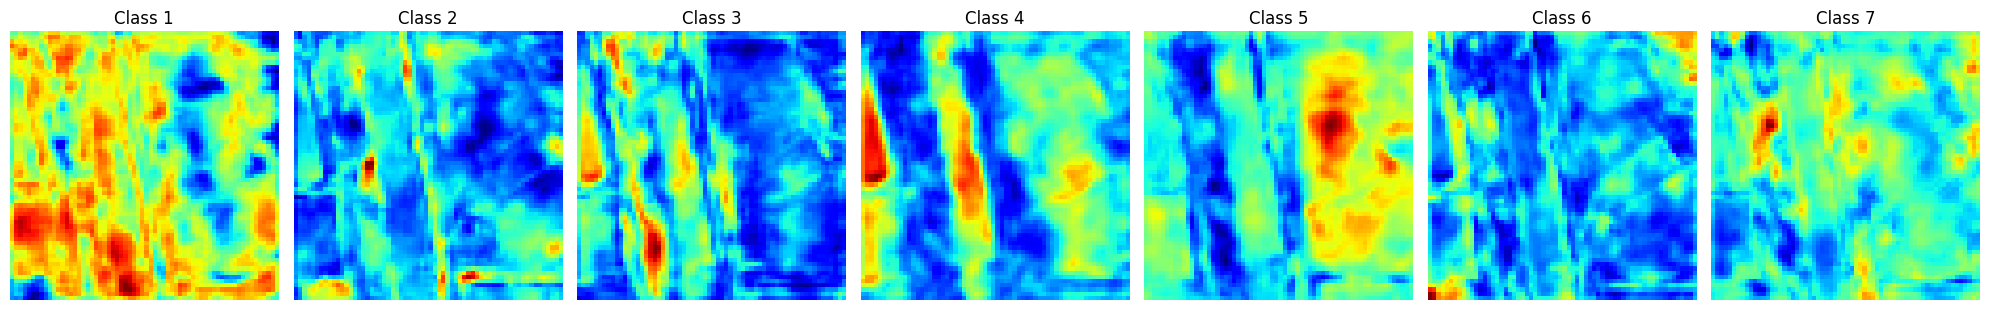

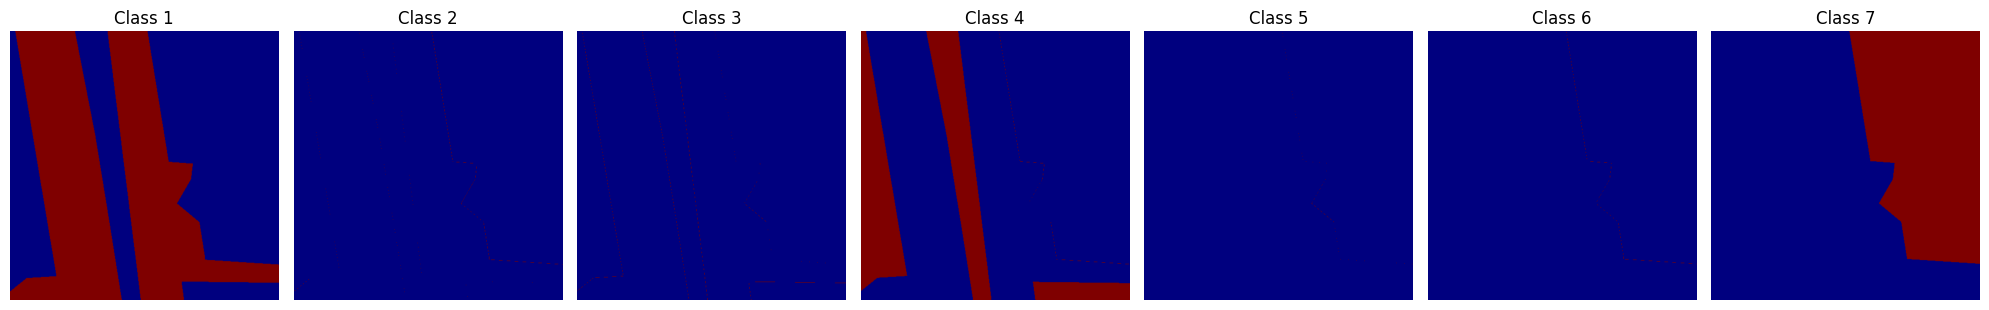

In [32]:
TRAINING=1
if TRAINING:  # Ensure you have a condition for training mode
    # Pick a random batch from the train loader
    a, b = val_dataset[200]
    inputs, targets = a, b  # Assuming the loader returns (input, target) pairs

    # Move the inputs and targets to the same device as the model
    inputs, targets = inputs.to(device), targets.to(device)

    inputs = inputs.unsqueeze(0)  # Add a batch dimension

    # Get the model output for the input
    model.eval()  # Make sure the model is in evaluation mode
    with torch.no_grad():
        output = model(inputs)  # Get model prediction for the input

    output = output[1]

    # Print the random input, output, and ground truth
    print("\nRandom Sample (Epoch {})".format(i))
    print("Input Tensor: ", inputs.shape)
    print("Ground Truth: ", targets.shape)
    print("Model Output: ", len(output))

    show_image(a)

    plt.imshow(b.argmax(dim=0)) #grouth truth mask
    plt.show()

    output = output.squeeze(0)

    plt.imshow(output.cpu().argmax(dim=0).numpy()) #

    fig, axes = plt.subplots(1, 7, figsize=(20, 5))

    # Itera attraverso i canali della maschera (7 classi)
    for i in range(7):
        # Estrai il canale i-esimo
        mask_class = output[i].cpu().numpy()  # Converti in array numpy per la visualizzazione

        # Visualizza la maschera della classe i
        axes[i].imshow(mask_class, cmap='jet')  # Usa una mappa di colori (ad esempio, 'jet')
        axes[i].set_title(f'Class {i + 1}')
        axes[i].axis('off')  # Disabilita gli assi

    # Mostra il risultato
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 7, figsize=(20, 5))

    # Itera attraverso i canali della maschera (7 classi)
    for i in range(7):
        # Estrai il canale i-esimo
        mask_class = targets[i].cpu().numpy()  # Converti in array numpy per la visualizzazione

        # Visualizza la maschera della classe i
        axes[i].imshow(mask_class, cmap='jet')  # Usa una mappa di colori (ad esempio, 'jet')
        axes[i].set_title(f'Class {i + 1}')
        axes[i].axis('off')  # Disabilita gli assi

    # Mostra il risultato
    plt.tight_layout()
    plt.show()

    model.train()

In [33]:
# --- Calcolo della Loss ---
criterion = torch.nn.CrossEntropyLoss()  # Definisci la funzione di perdita
# La loss richiede che il target sia di tipo (B, H, W), quindi rimuovi il one-hot encoding
targets_class = targets.argmax(dim=0).unsqueeze(0)  # Ground truth in formato (B, H, W)

# --- Upsample l'output del modello ---
# Porta l'output del modello alla stessa risoluzione del target (512 x 512)
output_resized = F.interpolate(output.unsqueeze(0), size=targets_class.shape[1:], mode='bilinear', align_corners=False)

loss = criterion(output_resized, targets_class)  # Calcola la loss

print(f"Loss per l'immagine corrente: {loss.item()}")

# --- Calcolo della mIoU ---
def compute_miou(pred_mask, true_mask, num_classes):
    iou_list = []
    for cls in range(num_classes):
        pred_cls = (pred_mask == cls)  # Predizione per la classe cls
        true_cls = (true_mask == cls)  # Ground truth per la classe cls

        intersection = (pred_cls & true_cls).sum().item()
        union = (pred_cls | true_cls).sum().item()

        if union == 0:
            iou = float('nan')  # Evita la divisione per zero
        else:
            iou = intersection / union

        iou_list.append(iou)

    miou = torch.tensor(iou_list).nanmean().item()  # Calcola la media ignorando NaN
    return miou

# Calcola la mIoU
predicted_mask_resized = output_resized.squeeze(0).argmax(dim=0).cpu()  # Maschera predetta upscalata
true_mask = targets_class.squeeze(0).cpu()  # Ground truth
num_classes = 7  # Numero di classi

miou = compute_miou(predicted_mask_resized, true_mask, num_classes)
print(f"Mean IoU per l'immagine corrente: {miou}")


Loss per l'immagine corrente: 3.100883960723877
Mean IoU per l'immagine corrente: 0.11184751242399216


In [17]:
model_path = "best_pidnet_model.pth"

# Crea un'istanza del modello
# model = get_seg_model()  # Sostituisci con la tua classe modello
%ls
# Carica i parametri salvati
model.load_state_dict(torch.load(model_path))


best_pidnet_model.pth   output/  PIDNet_S_ImageNet.pth.tar  Train/     Val/
Neural-Style-Transfer/  PIDNet/  sample_data/               Train.zip  Val.zip


<ipython-input-17-95aad97ebf34>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>